In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split

1. 数据处理

In [2]:
# 读入数据
moviesPath = 'movies.csv'
ratingsPath = 'ratings.csv'
moviesDF = pd.read_csv(moviesPath,index_col=None)
ratingsDF = pd.read_csv(ratingsPath,index_col=None)

In [3]:
ratingsDF.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
# 按照4：1的比例将数据集进行拆分，同时打印出总的用户和电影数量，
# 训练集中的用户和电影数量，以及测试集中的用户和电影数量：
trainRatingsDF,testRatingsDF = train_test_split(ratingsDF,test_size=0.2)

print("total_movie_count:"+str(len(set(ratingsDF['movieId'].values.tolist()))))
print("total_user_count:"+str(len(set(ratingsDF['userId'].values.tolist()))))
print("train_movie_count:"+str(len(set(trainRatingsDF['movieId'].values.tolist()))))
print("train_user_count:"+str(len(set(trainRatingsDF['userId'].values.tolist()))))
print("test_movie_count:"+str(len(set(testRatingsDF['movieId'].values.tolist()))))
print("test_user_count:"+str(len(set(testRatingsDF['userId'].values.tolist()))))

total_movie_count:9066
total_user_count:671
train_movie_count:8406
train_user_count:671
test_movie_count:4868
test_user_count:671


    所以，这里并不是所有的电影都被分到测试集和训练集中。

    接下来，我们得到用户-电影的评分矩阵，使用pandas的数据透视功能，同时，我们得到电影id和用户id与其对应索引的映射关系：

In [5]:
trainRatingsPivotDF = pd.pivot_table(trainRatingsDF[['userId','movieId','rating']],columns=['movieId'],index=['userId'],values='rating',fill_value=0)

In [6]:
trainRatingsPivotDF.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,160567,160590,160656,160718,161084,161830,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0,0,0.0,0,0.0,0,0.0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0,0,0.0,0,0.0,0,0.0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0,0,0.0,0,0.0,0,0.0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0,0,0.0,0,0.0,0,0.0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0,0,0.0,0,0.0,0,0.0,0,0,0


In [36]:
moviesMap = dict(enumerate(list(trainRatingsPivotDF.columns)))
len(moviesMap)

8406

In [37]:
usersMap = dict(enumerate(list(trainRatingsPivotDF.index)))
len(usersMap)

671

In [13]:
ratingValues = trainRatingsPivotDF.values.tolist()
print(len(ratingValues))
len(ratingValues[0])

671


8406

2. 用户相似度计算

In [14]:
# 这里我们使用余弦相似度来计算用户之间的相似度关系
def calCosineSimilarity(list1,list2):
    res = 0
    denominator1 = 0 # denominator分母
    denominator2 = 0
    for (val1,val2) in zip(list1,list2):
        res += (val1 * val2)
        denominator1 += val1 ** 2
        denominator2 += val2 ** 2
    return res / (math.sqrt(denominator1 * denominator2))    

    随后，需要计算用户之间的相似度矩阵，对于用户相似度矩阵，这是一个对称矩阵，同时对角线的元素为0，所以我们只需要计算上三角矩阵的值即可：

In [15]:
userSimMatrix = np.zeros((len(ratingValues),len(ratingValues)),dtype=np.float32)
userSimMatrix # 671 * 671

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
for i in range(len(ratingValues)-1):
    for j in range(i+1,len(ratingValues)):
        userSimMatrix[i,j] = calCosineSimilarity(ratingValues[i],ratingValues[j])
        userSimMatrix[j,i] = userSimMatrix[i,j]

In [31]:
userSimMatrix[0][0] # 671 * 671

0.0

    接下来，我们要找到与每个用户最相近的K个用户，用这K个用户的喜好来对目标用户进行物品推荐，这里K=10，下面的代码用来计算与每个用户最相近的10个用户。

In [22]:
userMostSimDict = dict()
for i in range(len(ratingValues)):
    userMostSimDict[i] = sorted(enumerate(list(userSimMatrix[0])),key = lambda x:x[1],reverse=True)[:10]

In [28]:
userMostSimDict # 671 * 10

[(324, 0.22555432),
 (309, 0.18161282),
 (538, 0.14577441),
 (228, 0.13713981),
 (275, 0.12696572),
 (206, 0.11997738),
 (194, 0.119596235),
 (496, 0.11870786),
 (34, 0.11777142),
 (279, 0.11715605)]

3. 电影推荐

   得到了每个用户对应的10个兴趣最相近的用户之后，我们根据下面的公式计算用户对每个没有观看过的电影的兴趣分：
    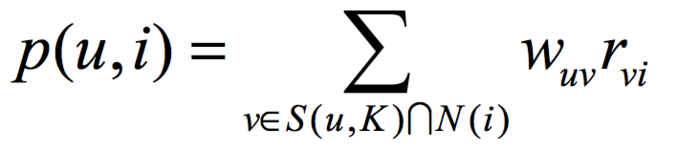

In [32]:
# 这里，如果用户已经对电影打过分，那么兴趣值就是0，代码如下：
userRecommendValues = np.zeros((len(ratingValues),len(ratingValues[0])),dtype=np.float32) # 671 * 8406
for i in range(len(ratingValues)): # 遍历所有用户 671
    for j in range(len(ratingValues[i])): # 遍历所有电影 8406
        if ratingValues[i][j] == 0:
            val = 0
            for (user,sim) in userMostSimDict[i]:
                val += (ratingValues[user][j] * sim)
            userRecommendValues[i,j] = val 

In [33]:
userRecommendValues

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

    接下来，我们为每个用户推荐10部电影：

In [34]:
userRecommendDict = dict()
for i in range(len(ratingValues)):
    userRecommendDict[i] = sorted(enumerate(list(userRecommendValues[i])),key = lambda x:x[1],reverse=True)[:10]

    将推荐的结果转为推荐列表之后，我们将推荐结果转换为二元组，这里要注意的是，我们一直使用的是索引，我们需要将索引的用户id和电影id转换为真正的用户id和电影id，这里我们前面定义的两个map就派上用场了：

In [38]:
userRecommendList = []
for key,value in userRecommendDict.items():
    user = userMap[key]
    for (movieId,val) in value:
        userRecommendList.append([user,moviesMap[movieId]])

    最后一步，我们将推荐结果的电影id转换为对应的电影名，并打印结果。

In [39]:
recommendDF = pd.DataFrame(userRecommendList,columns=['userId','movieId'])
recommendDF = pd.merge(recommendDF,moviesDF[['movieId','title']],on='movieId',how='inner')
recommendDF.tail(10)

,userId,movieId,title
6700,102,2028,Saving Private Ryan (1998)
6701,311,2028,Saving Private Ryan (1998)
6702,388,2028,Saving Private Ryan (1998)
6703,452,2028,Saving Private Ryan (1998)
6704,509,2028,Saving Private Ryan (1998)
6705,547,2028,Saving Private Ryan (1998)
6706,195,265,Like Water for Chocolate (Como agua para choco...
6707,358,265,Like Water for Chocolate (Como agua para choco...
6708,472,265,Like Water for Chocolate (Como agua para choco...
6709,358,1035,"Sound of Music, The (1965)"
